This notebook contains examples and strategies from Michael L. Halls-Moore's successful algorithmic trading book. For educational purposes only - not intended for live trading. Use at your own risk.

In [12]:
import numpy as np 
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from scipy import stats

# Testing Mean Reversion

### Augmented Dickey-Fuller (ADF) Test

The ADF test is used to check for the presence of a unit root in a time series, which helps determine if the series is stationary.

#### Mathematical Definition
The ADF regression equation is:

$$
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \delta_2 \Delta y_{t-2} + \dots + \delta_p \Delta y_{t-p} + \epsilon_t
$$

where:
- \( y_t \) is the value of the time series at time \( t \).
- \( \Delta y_t \) is the first difference of the series, i.e., \( y_t - y_{t-1} \).
- \( \alpha \) is a constant term (optional).
- \( \beta t \) is the trend term (optional).
- \( \gamma \) is the coefficient on the lagged level of \( y \), testing for a unit root.
- \( \delta_1, \delta_2, \dots, \delta_p \) are the coefficients of the lagged first-differenced terms.
- \( \epsilon_t \) is the error term.

#### Hypotheses
- **Null Hypothesis (\( H_0 \))**: The time series has a unit root, meaning it is **non-stationary** and does **not exhibit mean reversion**.
  - Mathematically: \( \gamma = 0 \)
- **Alternative Hypothesis (\( H_1 \))**: The time series is **stationary** and does **exhibit mean reversion**.
  - Mathematically: \( \gamma < 0 \)

#### Decision Rule
- If the **ADF test statistic** is more negative than the **critical value** (at a chosen significance level), or if the **p-value** is less than the significance level (e.g., 0.05), **reject the null hypothesis**. This suggests the time series is stationary.
- If the **ADF test statistic** is less negative than the **critical value**, or if the **p-value** is greater than the significance level, **fail to reject the null hypothesis**. This suggests the time series is non-stationary.


In [13]:
def adf_test(data):
    res = ts.adfuller(data['Close'], maxlag=1)
    return pd.Series({
        'ADF Test Statistic': res[0],
        'P-Value': res[1],
        'Sample Size': res[3],
        '1% Critical Value': res[4]['1%'],
        '5% Critical Value': res[4]['5%'],
        '10% Critical Value': res[4]['10%'],
    })
    

ticker = yf.Ticker("AAPL")
data = ticker.history(start='2024-01-01', end='2024-11-18')  
adf_test(data)

ADF Test Statistic     -0.824060
P-Value                 0.811952
Sample Size           221.000000
1% Critical Value      -3.460291
5% Critical Value      -2.874709
10% Critical Value     -2.573789
dtype: float64

##### We fail to reject the null hypothesis that the series has a unit root when p-value is higher than 0.05 or 0.10. This suggests that the time series is non-stationary and does not exhibit mean reversion in its current form (i.e., with a lag-1 form or as currently configured).

<module 'matplotlib.pyplot' from '/Users/derrine.chia/Library/Caches/pypoetry/virtualenvs/algorithmic-trading-PnVZwZ_3-py3.11/lib/python3.11/site-packages/matplotlib/pyplot.py'>

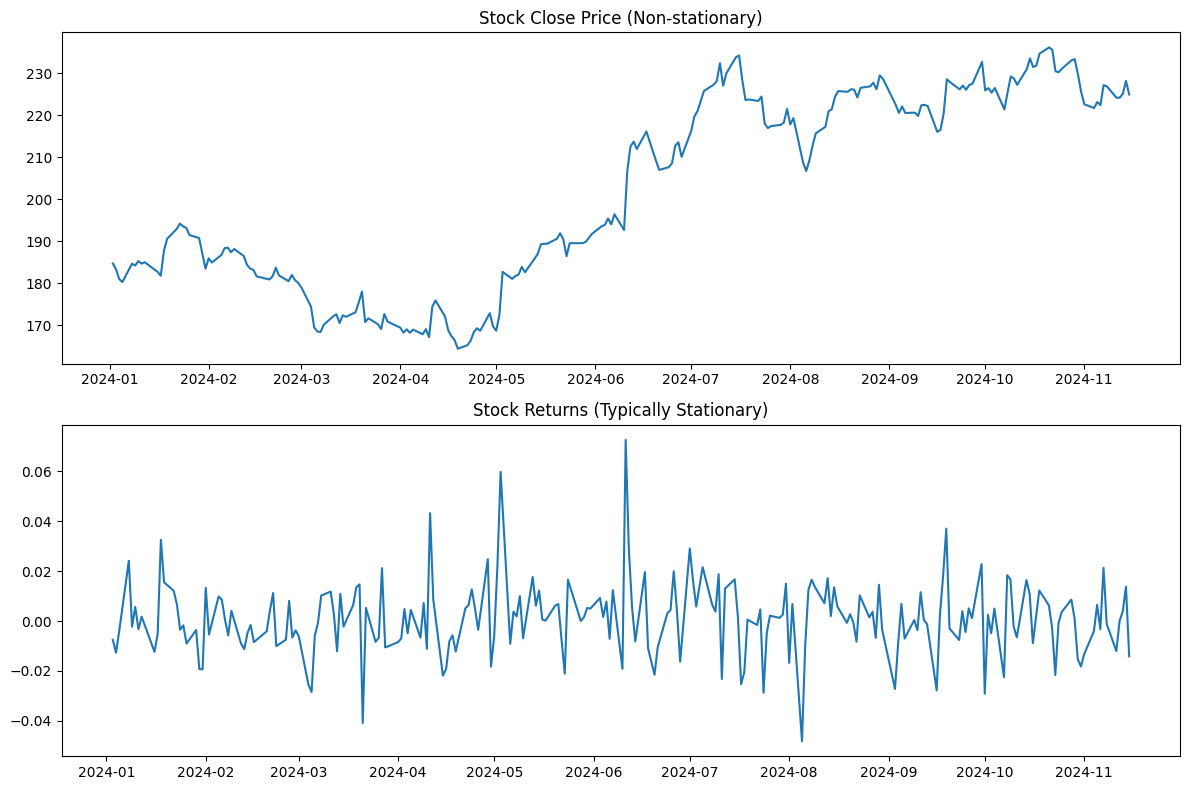

In [14]:
def plot_stock_price_returns(data):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    ax1.plot(data['Close'])
    ax1.set_title('Stock Close Price (Non-stationary)')
    returns = data['Close'].pct_change()
    ax2.plot(returns)
    ax2.set_title('Stock Returns (Typically Stationary)')
    plt.tight_layout()
    return plt


plot_stock_price_returns(data)

### Hurst Exponent Analysis

The Hurst exponent (H) is used to evaluate time series data to determine whether it is:
- Mean reverting
- Random walking
- Trending

#### Mathematical Definition
The Hurst exponent is calculated as:
```
H = log(R/S)/log(T)
```
where:
- R/S = rescaled range (the range of the data divided by standard deviation)
- T = time period
- H = Hurst exponent

#### Interpretation

1. **H ≈ 0.5: Random Walk (Brownian Motion)**
   - Indicates independent price movements
   - Past trends have no influence on future movements
   - Characteristic of traditional efficient markets
   - Example: H = 0.45 to 0.55

2. **H < 0.5: Mean-Reverting (Anti-Persistent)**
   - Strong mean-reverting tendencies
   - High volatility
   - Series more likely to reverse:
     * Upward trends tend to reverse downward
     * Downward trends tend to reverse upward
   - Example: H = 0.2 indicates strong mean reversion

3. **H > 0.5: Trend-Following (Persistent)**
   - Momentum or trend-following behavior
   - Low volatility
   - Series likely to continue current trend:
     * Upward trends tend to continue upward
     * Downward trends tend to continue downward
   - Example: H = 0.8 indicates strong trend-following

#### Trading Implications

1. **Mean-Reverting (H < 0.5)**
   - Best for range-bound trading strategies
   - Consider buying at support levels
   - Consider selling at resistance levels
   - Example strategies:
     * Mean reversion trading
     * Range trading
     * Pairs trading

2. **Random Walk (H ≈ 0.5)**
   - Best for diversification strategies
   - Consider longer holding periods
   - Focus on fundamental analysis

3. **Trend-Following (H > 0.5)**
   - Best for momentum strategies
   - Consider trend-following systems
   - Example strategies:
     * Moving average crossovers
     * Breakout trading
     * Momentum trading

#### Important Notes
- The Hurst exponent is not static and can change over time
- Should be used in conjunction with other technical indicators
- Past patterns do not guarantee future behavior
- Calculation window length can affect results

In [17]:
def hurst_exponent(price_data):
    ts = np.log(price_data)
    lags = range(2, min(100, len(ts)//2))
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0

symbols = ['NVDA', 'MSFT', 'JPM']
for symbol in symbols:
    stock = yf.download(symbol, start='2024-11-01', end='2024-11-20')
    h = hurst_exponent(stock['Adj Close'].values)
    print(f"Hurst({symbol}): {h:.3f}")
    # plot_stock_price_returns(stock)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Hurst(NVDA): 0.296
Hurst(MSFT): -0.104
Hurst(JPM): -0.200



These stocks show strong mean-reverting tendencies. After an upward trend, they're more likely to reverse downward. After a downward trend, they're more likely to reverse upward
JPM shows the strongest mean-reversion tendency, while NVDA shows the weakest mean-reversion among the three.

The negative Hurst exponents for MSFT and JPM indicate extremely strong mean reversion, even stronger than what positive values less than 0.5 would suggest. This means these stocks are showing very aggressive tendencies to reverse their price movements, requiring more careful risk management and potentially smaller position sizes due to the increased volatility.

# The End